## Описание работы: 
Ваша задача — провести оценку результатов A/B-теста. В вашем распоряжении есть датасет с действиями пользователей, техническое задание и несколько вспомогательных датасетов.

Оцените корректность проведения теста и проанализируйте его результаты.

Чтобы оценить корректность проведения теста:

- удостоверьтесь, что нет пересечений с конкурирующим тестом и нет пользователей, участвующих в двух группах теста одновременно;
- проверьте равномерность распределения пользователей по тестовым группам и правильность их формирования.

## Техническое задание:
- Название теста: `recommender_system_test`;
- группы: А — контрольная, B — новая платёжная воронка;
- дата запуска: 2020-12-07;
- дата остановки набора новых пользователей: 2020-12-21;
- дата остановки: 2021-01-04;
- аудитория: в тест должно быть отобрано 15% новых пользователей из региона EU;
- назначение теста: тестирование изменений, связанных с внедрением улучшенной рекомендательной системы;
- ожидаемое количество участников теста: 6000.
- ожидаемый эффект: за 14 дней с момента регистрации пользователи покажут улучшение каждой метрики не менее, чем на 10%:
    - конверсии в просмотр карточек товаров — событие `product_page`,
    - просмотры корзины — `product_cart`,
    - покупки — `purchase`.

## Описание данных:
`ab_project_marketing_events.csv` — календарь маркетинговых событий на 2020 год.

Структура файла:

- `name` — название маркетингового события;
- `regions` — регионы, в которых будет проводиться рекламная кампания;
- `start_dt` — дата начала кампании;
- `finish_dt` — дата завершения кампании.

`final_ab_new_users.csv` — пользователи, зарегистрировавшиеся с 7 до 21 декабря 2020 года.

Структура файла:

- `user_id` — идентификатор пользователя;
- `first_date` — дата регистрации;
- `region` — регион пользователя;
- `device` — устройство, с которого происходила регистрация.

`final_ab_events.csv` — действия новых пользователей в период с 7 декабря 2020 по 4 января 2021 года.

Структура файла:

- `user_id` — идентификатор пользователя;
- `event_dt` — дата и время события;
- `event_name` — тип события;
- `details` — дополнительные данные о событии. Например, для покупок, `purchase,` в этом поле хранится стоимость покупки в долларах.

`final_ab_participants.csv` — таблица участников тестов.

Структура файла:

- `user_id` — идентификатор пользователя;
- `ab_test` — название теста;
- `group` — группа пользователя.

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
from matplotlib import pyplot as plt
from plotly import graph_objects as go
from statsmodels. stats.weightstats import ztest as ztest
import math as mth
from scipy import stats as st

In [2]:
pd.set_option('display.max_columns', 50) 
pd.set_option('display.max_rows', 500)
pd.set_option('display.float_format', lambda x: '%.5f' % x)
pd.set_option('display.max_colwidth', False)
# параметры для корректного отображения таблиц и более удобного их анализа

In [3]:
marketing = pd.read_csv(sep=",")
new_users = pd.read_csv(sep=",")
events = pd.read_csv(sep=",")
participants = pd.read_csv(sep=",")

In [4]:
# функция для отображения часто используемых запросов
def info(df):
    display(df.head())
    display(df.info())
    display(df.isna().sum())
    display(df.duplicated().sum())

In [5]:
info(marketing)

,name,regions,start_dt,finish_dt
0,Christmas&New Year Promo,"EU, N.America",2020-12-25,2021-01-03
1,St. Valentine's Day Giveaway,"EU, CIS, APAC, N.America",2020-02-14,2020-02-16
2,St. Patric's Day Promo,"EU, N.America",2020-03-17,2020-03-19
3,Easter Promo,"EU, CIS, APAC, N.America",2020-04-12,2020-04-19
4,4th of July Promo,N.America,2020-07-04,2020-07-11


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14 entries, 0 to 13
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   name       14 non-null     object
 1   regions    14 non-null     object
 2   start_dt   14 non-null     object
 3   finish_dt  14 non-null     object
dtypes: object(4)
memory usage: 580.0+ bytes


None

name         0
regions      0
start_dt     0
finish_dt    0
dtype: int64

0

In [6]:
info(new_users)

,user_id,first_date,region,device
0,D72A72121175D8BE,2020-12-07,EU,PC
1,F1C668619DFE6E65,2020-12-07,N.America,Android
2,2E1BF1D4C37EA01F,2020-12-07,EU,PC
3,50734A22C0C63768,2020-12-07,EU,iPhone
4,E1BDDCE0DAFA2679,2020-12-07,N.America,iPhone


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 61733 entries, 0 to 61732
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   user_id     61733 non-null  object
 1   first_date  61733 non-null  object
 2   region      61733 non-null  object
 3   device      61733 non-null  object
dtypes: object(4)
memory usage: 1.9+ MB


None

user_id       0
first_date    0
region        0
device        0
dtype: int64

0

In [7]:
new_users['region'].value_counts()

EU           46270
N.America    9155 
CIS          3155 
APAC         3153 
Name: region, dtype: int64

In [8]:
info(events)

,user_id,event_dt,event_name,details
0,E1BDDCE0DAFA2679,2020-12-07 20:22:03,purchase,99.99000
1,7B6452F081F49504,2020-12-07 09:22:53,purchase,9.99000
2,9CD9F34546DF254C,2020-12-07 12:59:29,purchase,4.99000
3,96F27A054B191457,2020-12-07 04:02:40,purchase,4.99000
4,1FD7660FDF94CA1F,2020-12-07 10:15:09,purchase,4.99000


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 440317 entries, 0 to 440316
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   user_id     440317 non-null  object 
 1   event_dt    440317 non-null  object 
 2   event_name  440317 non-null  object 
 3   details     62740 non-null   float64
dtypes: float64(1), object(3)
memory usage: 13.4+ MB


None

user_id       0     
event_dt      0     
event_name    0     
details       377577
dtype: int64

0

In [9]:
events['details'].unique()

array([ 99.99,   9.99,   4.99, 499.99,    nan])

В этом поле хранится стоимость покупки в долларах. Остальные события не имеют детализации

In [10]:
events['event_name'].unique()

array(['purchase', 'product_cart', 'product_page', 'login'], dtype=object)

In [11]:
info(participants)

,user_id,group,ab_test
0,D1ABA3E2887B6A73,A,recommender_system_test
1,A7A3664BD6242119,A,recommender_system_test
2,DABC14FDDFADD29E,A,recommender_system_test
3,04988C5DF189632E,A,recommender_system_test
4,482F14783456D21B,B,recommender_system_test


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18268 entries, 0 to 18267
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   user_id  18268 non-null  object
 1   group    18268 non-null  object
 2   ab_test  18268 non-null  object
dtypes: object(3)
memory usage: 428.3+ KB


None

user_id    0
group      0
ab_test    0
dtype: int64

0

In [12]:
participants['ab_test'].unique()

array(['recommender_system_test', 'interface_eu_test'], dtype=object)

## Предобработка данных

In [13]:
marketing['start_dt'] = pd.to_datetime(marketing['start_dt'])
marketing['finish_dt'] = pd.to_datetime(marketing['finish_dt'])
new_users['first_date'] = pd.to_datetime(new_users['first_date'])
events['event_dt'] = pd.to_datetime(events['event_dt'])

## Оценка корректности теста

### Проверка соответствия данных требованиям технического задания.

#### Название теста: recommender_system_test

In [14]:
participants['ab_test'].unique()

array(['recommender_system_test', 'interface_eu_test'], dtype=object)

В датасете два разных теста. для анализа стоит оставить только нужный по ТЗ

In [15]:
recommender_system_test = participants.query("ab_test == 'recommender_system_test'")

#### Группы: А — контрольная, B — новая платёжная воронка;

In [16]:
# проверяем на попадание субъектов в две группы одновременно
recommender_system_test.groupby('user_id')['group'].nunique().reset_index().query('group > 1')

,user_id,group


#### Дата запуска: 2020-12-07

In [17]:
# присоединяем еще одну таблицу для обработки данных с датами
recommender_system_test = recommender_system_test.merge(new_users, how ='left', on='user_id')

#### Дата остановки набора новых пользователей: 2020-12-21;

In [18]:
# фильтруем пользователей по ТЗ
recommender_system_test = recommender_system_test.query('first_date > "2020-12-06" & first_date < "2020-12-22"')

#### Аудитория: в тест должно быть отобрано 15% новых пользователей из региона EU;

In [19]:
# смотрим процент EU пользователей от общего количества, попавших на тест
eu_users = recommender_system_test.query('region == "EU"')
eu_users.count()/recommender_system_test.count()*100

user_id      94.77690
group        94.77690
ab_test      94.77690
first_date   94.77690
region       94.77690
device       94.77690
dtype: float64

In [20]:
# смотрим процент отобранных EU queried от общего EU queried
k = new_users.query('region == "EU"')
kk = eu_users['region'].count()/k['region'].count()*100
kk

13.725956343202938

In [21]:
# смотрим процент всех отобранных от общего EU quired (все, кто попал в тест)
q = new_users.query('region == "EU"')
qq =recommender_system_test['region'].count()/k['region'].count()*100
qq

14.4823859952453

In [22]:
k['region'].count()

46270

In [23]:
f'Если смотреть соотношение изначально набранных, то процентное соотношение практически соответвует условию в ТЗ -- {round(qq, 2)}%. Если брать соотношение на обработанных от других регионов данных, то цифра немного уменьшается -- {round(kk, 2)}%'

'Если смотреть соотношение изначально набранных, то процентное соотношение практически соответвует условию в ТЗ -- 14.48%. Если брать соотношение на обработанных от других регионов данных, то цифра немного уменьшается -- 13.73%'

In [24]:
f'Доля пользователей , которые участвовали в тесте из Евросоюза, от общего числа пользователей из этого региона, которые были зарегистрированы на ресурсе в период с 07 по 21 декабря включительно составила {round(kk, 2)}%'

'Доля пользователей , которые участвовали в тесте из Евросоюза, от общего числа пользователей из этого региона, которые были зарегистрированы на ресурсе в период с 07 по 21 декабря включительно составила 13.73%'

In [25]:
new_new_users = pd.read_csv()
new_participants = pd.read_csv()

chislitel = new_participants.merge(new_new_users, on = 'user_id', how = 'left')\
    .query('ab_test == "recommender_system_test" & region == "EU"')



znamenal = new_new_users.query('first_date <= "2020-12-21" & region == "EU"')

len(chislitel) / len(znamenal)

0.15

#### Ожидаемое количество участников теста: 6000.

In [26]:
# смотрим сколько и из каких регионов попали на тест
recommender_system_test['region'].value_counts()

EU           6351
N.America    223 
APAC         72  
CIS          55  
Name: region, dtype: int64

В тест попали несколько пользователей из других регионов, 5% можно удалять(меньше 400 пользователей из 6701)

In [27]:
# считаем количество попавших на тест queried
eu_users.count()

user_id       6351
group         6351
ab_test       6351
first_date    6351
region        6351
device        6351
dtype: int64

При избавлении от пользователей из других регионов, то основное количество приближается к эталонным 6000, указанным в ТЗ.

#### Ожидаемый эффект: за 14 дней с момента регистрации пользователи покажут улучшение каждой метрики не менее, чем на 10%:

In [28]:
# добавляем столбец с датой последнего ивента
last_event = events.sort_values(by=['event_dt','user_id']).groupby(by='user_id', as_index=False)['event_dt'].max()
# мерджим в конечную таблицу с последней датой
recommender_system_test = recommender_system_test.merge(last_event, how='left', on ='user_id').rename(columns={'event_dt':'last_date'})
# переводим в datetime
recommender_system_test['last_date'] = pd.to_datetime(recommender_system_test['last_date']).dt.date
recommender_system_test['lifetime'] = (pd.to_datetime(recommender_system_test['last_date']) - pd.to_datetime(recommender_system_test['first_date'])).dt.days
# оставляем только пользователей с временем проведения до 15 дней
recommender_system_test = recommender_system_test.query("lifetime < 15")
recommender_system_test

,user_id,group,ab_test,first_date,region,device,last_date,lifetime
1,A7A3664BD6242119,A,recommender_system_test,2020-12-20,EU,iPhone,2020-12-25,5.00000
2,DABC14FDDFADD29E,A,recommender_system_test,2020-12-08,EU,Mac,2020-12-18,10.00000
3,04988C5DF189632E,A,recommender_system_test,2020-12-14,EU,iPhone,2020-12-25,11.00000
5,4FF2998A348C484F,A,recommender_system_test,2020-12-20,EU,Mac,2020-12-28,8.00000
6,7473E0943673C09E,A,recommender_system_test,2020-12-16,EU,iPhone,2020-12-19,3.00000
...,...,...,...,...,...,...,...,...
6692,6DC46FD66C7F126B,B,recommender_system_test,2020-12-07,N.America,Mac,2020-12-19,12.00000
6695,94786EB776B45914,A,recommender_system_test,2020-12-14,APAC,Android,2020-12-22,8.00000
6697,9D263B8EF15CF188,B,recommender_system_test,2020-12-16,N.America,Mac,2020-12-16,0.00000
6698,F2FBBA33F37DEC46,A,recommender_system_test,2020-12-18,APAC,Mac,2020-12-26,8.00000


К сожалению, попадание в тех задание по количеству пользователей(6000) не может осуществиться. Очень много пользователей, которые зарегестрировались, но не сделали потом ни одного действия. Они убираются вместе с фильтром по дням нахождения пользователя на сайте(колонка lifetime) и остается 3405 пользователей

In [29]:
recommender_system_test_funnel = recommender_system_test.merge(events, how ='inner', on='user_id')
recommender_system_test_funnel

,user_id,group,ab_test,first_date,region,device,last_date,lifetime,event_dt,event_name,details
0,A7A3664BD6242119,A,recommender_system_test,2020-12-20,EU,iPhone,2020-12-25,5.00000,2020-12-20 15:46:06,product_page,NaN
1,A7A3664BD6242119,A,recommender_system_test,2020-12-20,EU,iPhone,2020-12-25,5.00000,2020-12-21 00:40:59,product_page,NaN
2,A7A3664BD6242119,A,recommender_system_test,2020-12-20,EU,iPhone,2020-12-25,5.00000,2020-12-25 05:19:45,product_page,NaN
3,A7A3664BD6242119,A,recommender_system_test,2020-12-20,EU,iPhone,2020-12-25,5.00000,2020-12-20 15:46:02,login,NaN
4,A7A3664BD6242119,A,recommender_system_test,2020-12-20,EU,iPhone,2020-12-25,5.00000,2020-12-21 00:40:58,login,NaN
...,...,...,...,...,...,...,...,...,...,...,...
22461,6715343AFBA285AE,B,recommender_system_test,2020-12-07,CIS,Android,2020-12-14,7.00000,2020-12-07 10:12:15,login,NaN
22462,6715343AFBA285AE,B,recommender_system_test,2020-12-07,CIS,Android,2020-12-14,7.00000,2020-12-08 22:51:16,login,NaN
22463,6715343AFBA285AE,B,recommender_system_test,2020-12-07,CIS,Android,2020-12-14,7.00000,2020-12-09 02:28:03,login,NaN
22464,6715343AFBA285AE,B,recommender_system_test,2020-12-07,CIS,Android,2020-12-14,7.00000,2020-12-10 22:55:14,login,NaN


In [30]:
ab_funnel = (
    recommender_system_test_funnel
    .pivot_table(index='event_name', values='user_id', aggfunc='nunique')
    .reset_index()
)
# присваиваем событиям порядковые номера для сортировки
ab_funnel['event_name'] = ab_funnel['event_name'].replace({'login':'1', 'product_page':'2', 'product_cart': '3', 'purchase':'4'})
ab_funnel['event_name'] = ab_funnel['event_name'].astype(int)

ab_funnel = ab_funnel.sort_values(by='event_name', ignore_index=True)

# создаем столбец с процентным соотношением относительно предыдущего этапа(делаем воронку)
ab_funnel['percentage'] = (ab_funnel['user_id'].pct_change() + 1)*100
# возвращаем настоящие названия для удобства прочтения
ab_funnel['event_name'] = ab_funnel['event_name'].replace({1:'login', 2:'product_page', 3: 'product_cart', 4:'purchase'})
ab_funnel['percentage'].fillna(100, inplace=True)
ab_funnel

,event_name,user_id,percentage
0,login,3405,100.00000
1,product_page,2135,62.70191
2,product_cart,1015,47.54098
3,purchase,1059,104.33498


In [31]:
# готовим датафрейм с участниками только из группы A
a_funnel = (
    recommender_system_test_funnel
    .query('group == "A"')
    .pivot_table(index='event_name', values='user_id', aggfunc='nunique')
    .reset_index()
)
# присваиваем событиям порядковые номера для сортировки
a_funnel['event_name'] = a_funnel['event_name'].replace({'login':'1', 'product_page':'2', 'product_cart': '3', 'purchase':'4'})
a_funnel['event_name'] = a_funnel['event_name'].astype(int)

a_funnel = a_funnel.sort_values(by='event_name', ignore_index=True)

# создаем столбец с процентным соотношением относительно предыдущего этапа(делаем воронку)
a_funnel['percentage'] = (a_funnel['user_id'].pct_change() + 1)*100
# возвращаем настоящие названия для удобства прочтения
a_funnel['event_name'] = a_funnel['event_name'].replace({1:'login', 2:'product_page', 3: 'product_cart', 4:'purchase'})
a_funnel['percentage'].fillna(100, inplace=True)
a_funnel

,event_name,user_id,percentage
0,login,2591,100.00000
1,product_page,1677,64.72404
2,product_cart,788,46.98867
3,purchase,832,105.58376


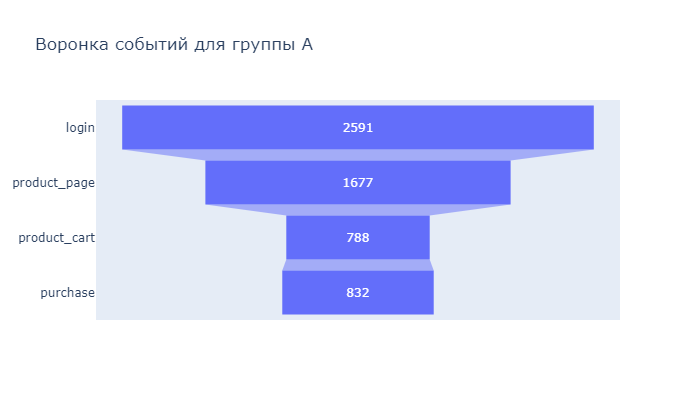

In [32]:
# строим воронку переходов по событиям для группы A
fig = go.Figure(go.Funnel(
    y = a_funnel['event_name'],
    x = a_funnel['user_id']))

fig.update_layout(title={'text': "Воронка событий для группы A"},
                 autosize=False,
                 width=700,
                 height=400)
fig.show("png")

In [33]:
# готовим датафрейм с участниками только из группы B
b_funnel = (
    recommender_system_test_funnel
    .query('group == "B"')
    .pivot_table(index='event_name', values='user_id', aggfunc='nunique')
    .reset_index()
)
# присваиваем событиям порядковые номера для сортировки
b_funnel['event_name'] = b_funnel['event_name'].replace({'login':'1', 'product_page':'2', 'product_cart': '3', 'purchase':'4'})
b_funnel['event_name'] = b_funnel['event_name'].astype(int)

b_funnel = b_funnel.sort_values(by='event_name', ignore_index=True)

# создаем столбец с процентным соотношением относительно предыдущего этапа(делаем воронку)
b_funnel['percentage'] = (b_funnel['user_id'].pct_change() + 1)*100
# возвращаем настоящие названия для удобства прочтения
b_funnel['event_name'] = b_funnel['event_name'].replace({1:'login', 2:'product_page', 3: 'product_cart', 4:'purchase'})
b_funnel['percentage'].fillna(100, inplace=True)
b_funnel

,event_name,user_id,percentage
0,login,814,100.00000
1,product_page,458,56.26536
2,product_cart,227,49.56332
3,purchase,227,100.00000


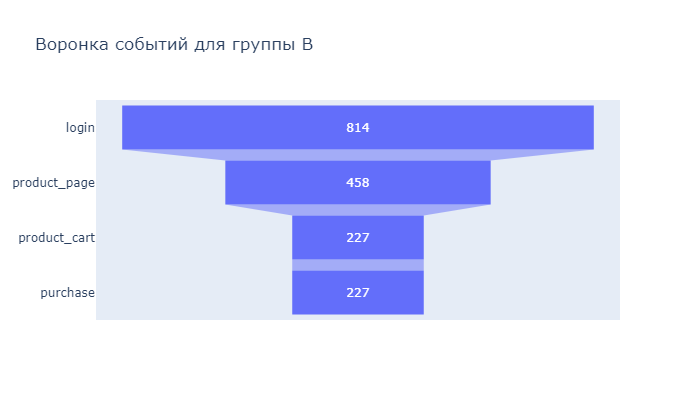

In [34]:
# строим воронку переходов по событиям для группы A
fig = go.Figure(go.Funnel(
    y = b_funnel['event_name'],
    x = b_funnel['user_id']))

fig.update_layout(title={'text': "Воронка событий для группы B"},
                 autosize=False,
                 width=700,
                 height=400)
fig.show("png")

In [35]:
# посмотрим улучшение конверсии относительно группы B к A
b_funnel['percentage']/a_funnel['percentage'] * 100

0   100.00000
1   86.93115 
2   105.47930
3   94.71154 
Name: percentage, dtype: float64

Улучшения ни одной метрики не произошло на желаемый уровень

### Время проведения теста. Убедитесь, что оно не совпадает с маркетинговыми и другими активностями.

In [36]:
marketing[marketing['regions'].str.contains('EU', regex=True, na=True)].query("start_dt > '2020-12-06'")

,name,regions,start_dt,finish_dt
0,Christmas&New Year Promo,"EU, N.America",2020-12-25,2021-01-03


Новогоднее и рождественское промо не захватывает период набора участников, но попадает на конец теста, что может негативно влиять на его результаты

### Проверка аудитории теста. Удостоверьтесь, что нет пересечений с конкурирующим тестом и нет пользователей, участвующих в двух группах теста одновременно. 

In [37]:
# создадим датасет с пользователями из другого теста
interface_eu_test = participants.query("ab_test == 'interface_eu_test'")
# присоеденим две таблицы для нахождения пользователей, попавших в оба теста
both_tests = recommender_system_test.merge(interface_eu_test, how='inner', on ='user_id')
both_tests

,user_id,group_x,ab_test_x,first_date,region,device,last_date,lifetime,group_y,ab_test_y
0,DABC14FDDFADD29E,A,recommender_system_test,2020-12-08,EU,Mac,2020-12-18,10.00000,A,interface_eu_test
1,04988C5DF189632E,A,recommender_system_test,2020-12-14,EU,iPhone,2020-12-25,11.00000,A,interface_eu_test
2,B3A2485649E4A012,A,recommender_system_test,2020-12-09,EU,iPhone,2020-12-10,1.00000,A,interface_eu_test
3,EAFB9027A27D510C,B,recommender_system_test,2020-12-07,EU,Android,2020-12-10,3.00000,A,interface_eu_test
4,5D5E6EE92AF6E9E0,B,recommender_system_test,2020-12-21,EU,Android,2020-12-24,3.00000,B,interface_eu_test
...,...,...,...,...,...,...,...,...,...,...
818,A0BAE4190D41A285,A,recommender_system_test,2020-12-07,EU,Android,2020-12-13,6.00000,A,interface_eu_test
819,28F165B39D160BC5,A,recommender_system_test,2020-12-14,EU,PC,2020-12-21,7.00000,A,interface_eu_test
820,96BDD55846D1F7F6,A,recommender_system_test,2020-12-20,EU,iPhone,2020-12-29,9.00000,B,interface_eu_test
821,FA86D8DFAD3ADADE,A,recommender_system_test,2020-12-14,EU,iPhone,2020-12-20,6.00000,A,interface_eu_test


In [38]:
# смотрим количество участников попавших одновременно в два теста(recommender_system_test и interface_eu_test) по группам
# в тесте recommender_system_test
both_tests['group_x'].value_counts()

A    629
B    194
Name: group_x, dtype: int64

In [39]:
# смотрим количество участников попавших одновременно в два теста(recommender_system_test и interface_eu_test) по группам
# в тесте interface_eu_test
both_tests['group_y'].value_counts()

A    420
B    403
Name: group_y, dtype: int64

Большинство участников теста, которые попали и туда и туда сосредоточились в группе "A"(в датасете с нужным нам тестом), что не влияет на тест. В группу "B" попало всего 194 пользователя. 

In [40]:
#проверяем на попадание субъектов в две группы одновременно
recommender_system_test.groupby('user_id')['group'].nunique().reset_index().query('group > 1')

,user_id,group


In [41]:
recommender_system_test_funnel['event_dt'].max()

Timestamp('2020-12-29 23:38:29')

Последнее событие произошло в конце дня 29 декабря, что на неделю раньше, чем ожидаемая дата завершения теста по ТЗ

### Исследовательский анализ данных

#### Количество событий на пользователя одинаково распределены в выборках?

In [42]:
a_events = (
recommender_system_test_funnel
    .query('group == "A"')
    .pivot_table(index='user_id', values='event_name', aggfunc='count')
)

In [43]:
b_events = (
recommender_system_test_funnel
    .query('group == "B"')
    .pivot_table(index='user_id', values='event_name', aggfunc='count')
)

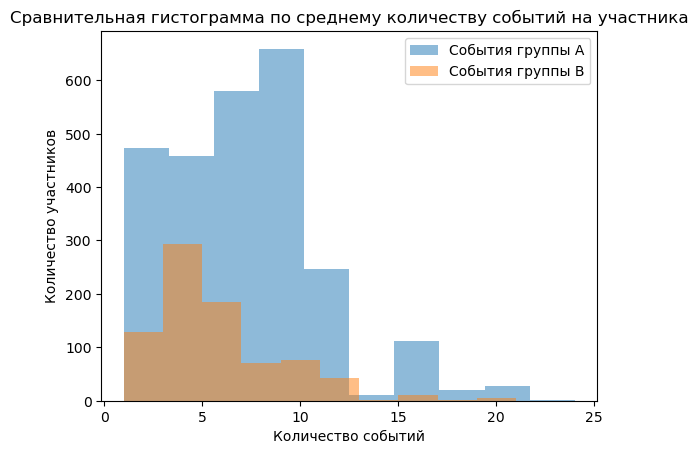

In [44]:
plt.title('Сравнительная гистограмма по среднему количеству событий на участника')
plt.hist(a_events, alpha=0.5, label='События группы A')
plt.hist(b_events, alpha=0.5, label='События группы B')
plt.legend(loc='upper right')
plt.xlabel('Количество событий')
plt.ylabel('Количество участников');

В группе A среднее количество событий превалирует над группой B и имеет пик на значении 10, когда в группе B пик приходится на значение около 5

#### Как число событий в выборках распределено по дням?

In [45]:
# создаем датафрейм для группы A
days_a = recommender_system_test_funnel
days_a['event_dt'] = pd.to_datetime(days_a['event_dt']).dt.strftime('%Y-%m-%d')
days_a = (
recommender_system_test_funnel
    .query('group == "A"')
    .pivot_table(index='event_dt', values='event_name', aggfunc='count')
    .reset_index()
)
days_a = days_a.rename(columns={'event_name':'A'})
# добавляем столбец с процентным соотношением количества событий по дням
days_a['percentage_a'] = (days_a['A'] / days_a['A'].sum())*100

In [46]:
# создаем датафрейм для группы B
days_b = recommender_system_test_funnel
days_b['event_dt'] = pd.to_datetime(days_b['event_dt']).dt.strftime('%Y-%m-%d')
days_b = (
recommender_system_test_funnel
    .query('group == "B"')
    .pivot_table(index='event_dt', values='event_name', aggfunc='count')
    .reset_index()
)
days_b = days_b.rename(columns={'event_name':'B'})
# добавляем столбец с процентным соотношением количества событий по дням
days_b['percentage_b'] = (days_b['B'] / days_b['B'].sum())*100

In [47]:
days_ab = days_a.merge(days_b, how='outer', on='event_dt')

''

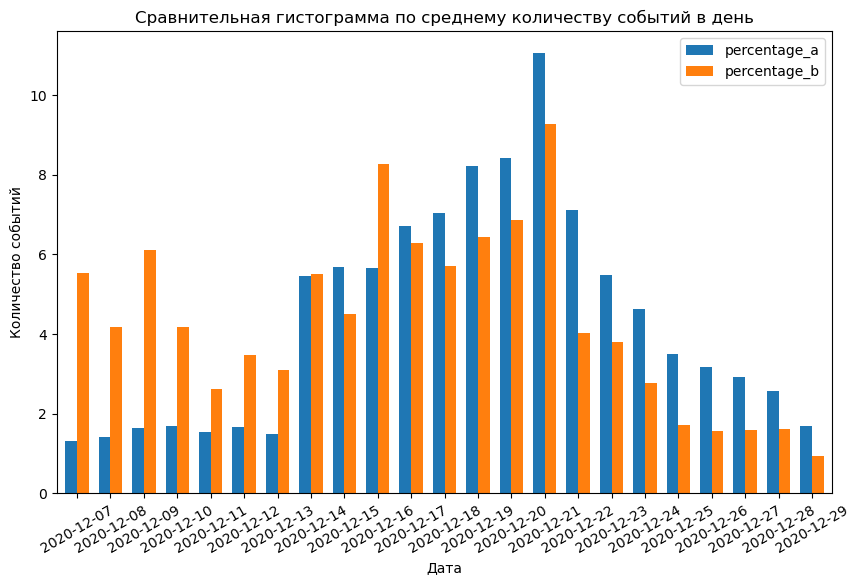

In [48]:
days_ab.pivot_table(index='event_dt', values=['percentage_a', 'percentage_b']).plot(kind='bar', figsize=(10, 6), width = 0.7)
plt.xticks(rotation=30)
plt.title('Сравнительная гистограмма по среднему количеству событий в день')
plt.xlabel('Дата')
plt.ylabel('Количество событий')
;

Было использовано процентное соотношение, в связи с разным количеством участников в каждой группе.

В начале группа B сильно больше выражена большим количеством событий в день(первые 6 дней в 2-3 раза больше событий). Начиная с 8 дня увеличивается количество событий в группе A, и оно обходит по значению группу B в среднем на 1-2% всегда до самого конца теста.

#### Какие особенности данных нужно учесть, прежде чем приступать к A/B-тестированию?

In [49]:
recommender_system_test['group'].value_counts()

A    2591
B    814 
Name: group, dtype: int64

<Axes: ylabel='group'>

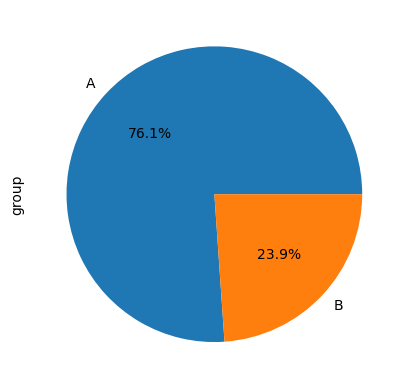

In [50]:
recommender_system_test['group'].value_counts().plot(kind='pie', autopct='%1.1f%%')

Очень большое количество участников теста не совершали никаких событий, соответственно у нас был перевес по группам A и B. В группе A активных участников 76% с количеством 2591, когда в группе B всего 24% и 814 человек

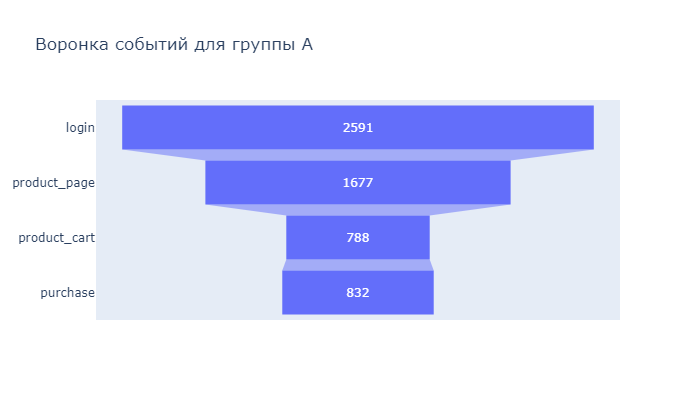

In [51]:
# строим воронку переходов по событиям для группы A
fig = go.Figure(go.Funnel(
    y = a_funnel['event_name'],
    x = a_funnel['user_id']))

fig.update_layout(title={'text': "Воронка событий для группы A"},
                 autosize=False,
                 width=700,
                 height=400)
fig.show("png")

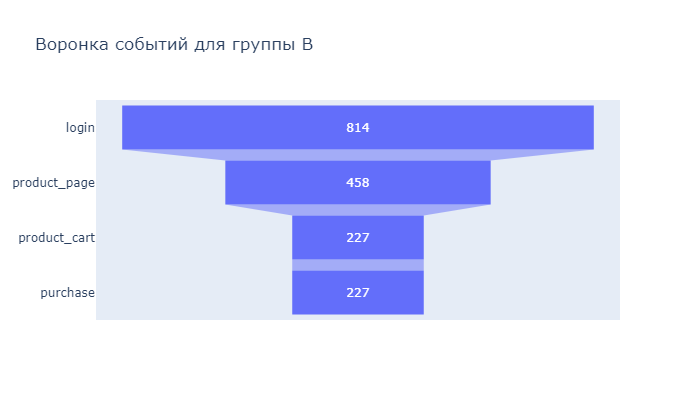

In [52]:
# строим воронку переходов по событиям для группы A
fig = go.Figure(go.Funnel(
    y = b_funnel['event_name'],
    x = b_funnel['user_id']))

fig.update_layout(title={'text': "Воронка событий для группы B"},
                 autosize=False,
                 width=700,
                 height=400)
fig.show("png")

In [53]:
# посмотрим улучшение конверсии относительно группы B к A
b_funnel['percentage']/a_funnel['percentage'] * 100

0   100.00000
1   86.93115 
2   105.47930
3   94.71154 
Name: percentage, dtype: float64

### Оценка результатов A/B теста

#### Что можно сказать про результаты A/В-тестирования?

A/B тест был проведен некорректно. Результаты можно использовать, но лучше подготовить повторное исследование. <br>
Проблемы:
* Большое количество участников попали в два разных исследования
* Исследование частично попало в даты проводимого ивента
* Большое количество участников выпали из выборки из-за того, что не совершали никаких действий
* 


#### Проверьте статистическую разницу долей z-критерием.

Нулевая гипотеза: Разницы между долями нет, они равны <br>
Альтернативная гипотеза: Между долями есть значимая разница<br>
Уровень статистической значимости = 0.05<br>
Используемый тест: z-критерий

Поскольку будет производиться сравнение одних и тех же данных несколько раз, нужно вводить поправку на множественную проверку гипотез

In [54]:
f'Поправка Бонферонни равна {0.05/3}'

'Поправка Бонферонни равна 0.016666666666666666'

In [55]:
def test(successes1, successes2, trials1, trials2, alpha):
# пропорция успехов в первой группе:
    p1 = successes1/trials1

# пропорция успехов во второй группе:
    p2 = successes2/trials2
    
    print(successes1, successes2, trials1, trials2)

# пропорция успехов в комбинированном датасете:
    p_combined = (successes1 + successes2) / (trials1 + trials2)

# разница пропорций в датасетах
    difference = p1 - p2 

# считаем статистику в ст.отклонениях стандартного нормального распределения
    z_value = difference / mth.sqrt(p_combined * (1 - p_combined) * (1/trials1 + 1/trials2))

# задаем стандартное нормальное распределение (среднее 0, ст.отклонение 1)
    distr = st.norm(0, 1)  
    p_value = (1 - distr.cdf(abs(z_value))) * 2

    print('p-значение: ', p_value)

    if p_value < alpha:
        print('Отвергаем нулевую гипотезу: между долями есть значимая разница')
    else:
        print(
            'Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными'
        )  

In [56]:
print('Проводим тест по событию product_page')
test(a_funnel.loc[1, 'user_id'], b_funnel.loc[1, 'user_id'], a_funnel.loc[0, 'user_id'], b_funnel.loc[0, 'user_id'], 0.0167)

Проводим тест по событию product_page
1677 458 2591 814
p-значение:  1.3417644051605393e-05
Отвергаем нулевую гипотезу: между долями есть значимая разница


In [57]:
f"Соотношение группы A и группы B на первом этапе: {(a_funnel.loc[1, 'user_id']/a_funnel.loc[0, 'user_id'])/(b_funnel.loc[1, 'user_id']/b_funnel.loc[0, 'user_id'])}"

'Соотношение группы A и группы B на первом этапе: 1.1503356428618376'

In [58]:
print('Проводим тест по событию product_cart')
test(a_funnel.loc[2, 'user_id'], b_funnel.loc[2, 'user_id'], a_funnel.loc[0, 'user_id'], b_funnel.loc[0, 'user_id'], 0.0167)

Проводим тест по событию product_cart
788 227 2591 814
p-значение:  0.1693263839891459
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


In [59]:
print('Проводим тест по событию purchase')
test(a_funnel.loc[3, 'user_id'], b_funnel.loc[3, 'user_id'], a_funnel.loc[0, 'user_id'], b_funnel.loc[0, 'user_id'], 0.0167)

Проводим тест по событию purchase
832 227 2591 814
p-значение:  0.02314148152242912
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


Переход на событие product_page отличается в долях. Остальные два события равны. <br>
Путем простого сравнения долей, было выявлено, что группа A на первом этапе ведет себя лучше

### Выводы:

При изучении среднего количества событий на участника по тестам побеждает группа A. Они делают на пике практически в два раза больше, чем участники из группы B.<br>
То же самое видно и на гистограмме по среднему количеству событий в день. Там побеждает группа A и обходит группу B на каждом дне на 1-2%.<br>
Тест имеет много ошибок в подготовке и выборе участников, но все же его результаты можно использовать для анализа. <br>
Проведя z-тесты было выявлено, что выборка из теста A лучше проходит на первый этап. Когда остальные этапы обе группы проходят одинаково.<br>
**Вывод:** A/B тест показал, что не стоит ничего изменять, для сохранения исходной конверсии и не потерять пользователей